# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Atacar a la API de Twitter
5. Predecir los nuevos Tweets

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Leemos el dataset

In [2]:
tree = ET.parse('data/general-train-tagged.xml')
root = tree.getroot()

In [3]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


### Columna de polaridad

In [4]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

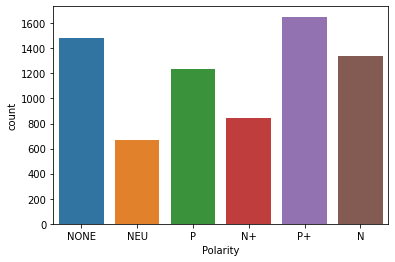

In [5]:
sns.countplot(x='Polarity', data=df);

#### Columna de tipo

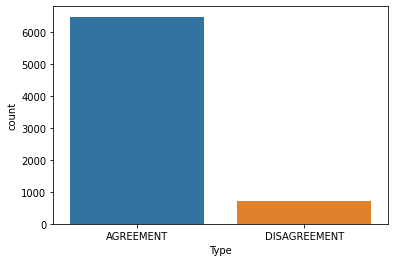

In [7]:
sns.countplot(x ='Type', data = df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [9]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [8]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [10]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

<ipython-input-10-538f1ed006b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Polarity'].apply(polaridad_fun)


array([0, 1], dtype=int64)

#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [11]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [12]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

#### Duplicados

In [13]:
# Eliminamos los duplicados
df.drop_duplicates(subset='Content', inplace=True)
df.shape

(5052, 6)

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [14]:
df['Content'].head()

2                            @marodriguezb Gracias MAR
3    Off pensando en el regalito Sinde, la que se v...
4    Conozco a alguien q es adicto al drama! Ja ja ...
6    Toca @crackoviadeTV3 . Grabación dl especial N...
8    Buen día todos! Lo primero mandar un abrazo gr...
Name: Content, dtype: object

In [15]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

2                            @marodriguezb gracias mar
3    off pensando en el regalito sinde la que se va...
4    conozco a alguien q es adicto al drama ja ja j...
6    toca @crackoviadetv  grabación dl especial nav...
8    buen día todos lo primero mandar un abrazo gra...
Name: Content, dtype: object

#### Eliminamos links

In [16]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [17]:
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

,User,Content,Date,Lang,Polarity,Type
2,CarmendelRiego,@marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT
3,mgilguerrero,off pensando regalito sinde va sgae van corrup...,2011-12-02T02:33:37,es,1,AGREEMENT
4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT
6,Carlos_Latre,toca @crackoviadetv grabación dl especial navi...,2011-12-02T07:00:50,es,0,AGREEMENT
8,nacho_uriarte,buen día primero mandar abrazo grande miguel f...,2011-12-02T07:45:05,es,0,AGREEMENT


#### Stemmer

In [18]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [19]:
df = df[['Content', 'Polarity']]

#### Vectorizamos el dataset

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

#### Montamos Pipeline
Modelos que suelen funcionar bien con pocas observaciones y muchas features son la Regresión logística el LinearSVC o Naive Bayes.

In [22]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC())
])

# Aqui definimos el espacio de parámetros a explorar
parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
    'cls__C': (0.2, 0.5, 0.7),
    'cls__loss': ('hinge', 'squared_hinge'),
    'cls__max_iter': (500, 1000)
}


grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv=5,
                          n_jobs=-1,
                          scoring='accuracy')

#### Entrenamos

In [23]:
grid_search.fit(df['Content'], df['Polarity'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls', LinearSVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__loss': ('hinge', 'squared_hinge'),
                         'cls__max_iter': (500, 1000),
                         'vect__max_df': (0.5, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [25]:
df.head()

,Content,Polarity
2,@marodriguezb graci mar,0
3,off pens regalit sind va sga van corrupt inten...,1
4,conozc algui q adict dram ja ja ja suen d,0
6,toc @crackoviadetv grabacion dl especial navid...,0
8,buen dia primer mand abraz grand miguel famili...,0


In [24]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__C': 0.2, 'cls__loss': 'squared_hinge', 'cls__max_iter': 500, 'vect__max_df': 0.5, 'vect__max_features': 1000, 'vect__min_df': 10, 'vect__ngram_range': (1, 2)}
Best acc: 0.744060874930223
Best model: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=10,
                                 ngram_range=(1, 2))),
                ('cls', LinearSVC(C=0.2, max_iter=500))])


#### Guardamos el modelo

In [26]:
import pickle

with open('finished_model.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

## 4. Predicciones
#### API de Twitter
Lo primero que tenemos que hacer es conseguir nuevos Tweets. Para ello:
1. Nos registramos en la [web de desarrolladores de Twitter](https://developer.twitter.com/en/apply-for-access)
2. Bajamos el paquete `tweepy` para atacara  la API de Twitter
3. Buscamos un Hashtag de tendencia
4. Nos logamos y monitorizamos el hastag
5. Aplicamos la limpieza a los Tweets
6. Predecimos la polaridad

In [ ]:
# !pip install tweepy

In [27]:
import tweepy  
import time
import csv

import json

with open('./credentials.json') as f:
    credentials = json.load(f)
    
    
# Credenciales de la web de desarroladores
access_token = credentials['access_token']  
access_token_secret = credentials['access_token_secret']  
consumer_key = credentials['consumer_key']
consumer_secret = credentials['consumer_secret'] 

# Nos autenticamos en la API
try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)  
    auth.set_access_token(access_token, access_token_secret)  
    api = tweepy.API(auth,wait_on_rate_limit=True)
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [35]:
raw_dict = {
    'author_name': [],
    'created_at': [],
    'content': [],
    'author_description': [],
    'author_followers_count': [],
    'author_profile_image_url': [],
    'author_location': [],
    'author_profile_background_image_url': [],
    'author_notifications': [],
    'geo': [],
    'coordinates': [],
    'entities': [],
    'place': []
}

# https://docs.tweepy.org/en/latest/api.html#search-methods

cursor = tweepy.Cursor(api.search,
                      q="Abascal",
                      count=100,
                      lang="es",
                      since="2021-04-06",
                      geocode="40.366063,-3.606238,100km").items(100)

for tweet in cursor:
    
    raw_dict['author_name'].append(tweet.author.name)
    raw_dict['created_at'].append(tweet.created_at)
    raw_dict['content'].append(tweet.text)
    raw_dict['author_description'].append(tweet.author.description)
    raw_dict['author_followers_count'].append(tweet.author.followers_count)
    raw_dict['author_profile_image_url'].append(tweet.author.profile_image_url)
    raw_dict['author_location'].append(tweet.author.location)
    raw_dict['author_profile_background_image_url'].append(tweet.author.profile_background_image_url)
    raw_dict['author_notifications'].append(tweet.author.notifications)
    raw_dict['geo'].append(tweet.geo)
    raw_dict['coordinates'].append(tweet.coordinates)
    raw_dict['entities'].append(tweet.entities)
    raw_dict['place'].append(tweet.place)
    

test = pd.DataFrame(raw_dict)
test.head()

,author_name,created_at,content,author_description,author_followers_count,author_profile_image_url,author_location,author_profile_background_image_url,author_notifications,geo,coordinates,entities,place
0,Zask Kántifas,2021-04-08 10:45:25,"RT @AntonioMaestre: Abascal buscaba violencia,...",Antifascistas. Sin lugar a equívocos. \nAquí n...,381,http://pbs.twimg.com/profile_images/1376980914...,,None,False,None,None,"{'hashtags': [], 'symbols': [], 'user_mentions...",None
1,Kike Fuentes 🔻,2021-04-08 10:45:25,"RT @AntonioMaestre: Abascal buscaba violencia,...",Que nadie te convenza que no se pueden cambiar...,1090,http://pbs.twimg.com/profile_images/1354217060...,Cardedeu,http://abs.twimg.com/images/themes/theme18/bg.gif,False,None,None,"{'hashtags': [], 'symbols': [], 'user_mentions...",None
2,Jorge Seguí,2021-04-08 10:45:23,RT @COPE: Interior defiende su dispositivo en ...,"De la Comunidad Valenciana, !! no apreciamos e...",656,http://pbs.twimg.com/profile_images/1303265955...,"Comunidad Valenciana, España",None,False,None,None,"{'hashtags': [], 'symbols': [], 'user_mentions...",None
3,Francisca,2021-04-08 10:45:18,RT @Guerraeterna: He estado a unos 10-15 metro...,Madrid. No pienso callar.,884,http://pbs.twimg.com/profile_images/5732272469...,,http://abs.twimg.com/images/themes/theme1/bg.png,False,None,None,"{'hashtags': [], 'symbols': [], 'user_mentions...",None
4,miloscastro,2021-04-08 10:45:15,RT @Tonicanto1: Lo que vimos ayer en Vallecas ...,"Estudiar, aprender, transmitir, repetir.",369,http://pbs.twimg.com/profile_images/1260909849...,,http://abs.twimg.com/images/themes/theme1/bg.png,False,None,None,"{'hashtags': [], 'symbols': [], 'user_mentions...",None


In [36]:
print(test.shape)
print(test.author_profile_image_url[25])

(100, 13)
http://pbs.twimg.com/profile_images/1251774768258469889/YT9WPgbH_normal.jpg


In [37]:
test['place'].unique()

array([None], dtype=object)

#### Limpieza de test

In [38]:
test_clean = test.copy()

# Seleccion de columnas
test_clean = test_clean[['content']]

# Eliminar duplicados
test_clean.drop_duplicates(subset='content', inplace=True)

# Signos de puntuacion
test_clean['content_clean'] = test_clean['content'].apply(signs_tweets)

# Eliminamos links
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_links)

# Nos cargamos stopwords
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_stopwords)

# Aplicamos el Stemmer
test_clean['content_clean'] = test_clean['content_clean'].apply(spanish_stemmer)
test_clean.shape

(41, 2)

#### Leemos el pipeline con el modelo

In [39]:
with open('finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)
    
print(pipeline_importada)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=10,
                                 ngram_range=(1, 2))),
                ('cls', LinearSVC(C=0.2, max_iter=500))])


#### Predicciones de test

In [40]:
predictions = pipeline_importada.predict(test_clean['content_clean'])

test_clean['Polarity'] = pd.Series(predictions)
for i in test_clean[:20].iterrows():
    print(i[1]['Polarity'])
    print(i[1]['content'])
    print('\n')

1.0
RT @AntonioMaestre: Abascal buscaba violencia, y como no la encontraba la comenzó

 https://t.co/sSwFFFjMGF


0.0
RT @COPE: Interior defiende su dispositivo en Vallecas ante las críticas de Vox y del sindicato policial Jupol https://t.co/JR8zbNeqDS


0.0
RT @Guerraeterna: He estado a unos 10-15 metros del escenario durante el mitin de Vox en Vallecas. Los incidentes han comenzado cuando Abas…


0.0
RT @Tonicanto1: Lo que vimos ayer en Vallecas es inadmisible.

Cualquier demócrata español tiene derecho a hacer lo que le dé la gana en te…


0.0
RT @AntonioMaestre: Abascal agrede a Vallecas 

Mi artículo en @laSextaTV sobre lo que sucedió ayer

https://t.co/sSwFFFjMGF


0.0
RT @AntonioMaestre: Abascal ha sido el responsable de cualquier acto violento al ir a encararse con los vecinos. https://t.co/9bVaQ4lGwJ


1.0
RT @DaniGagoPhoto: Dos codazos en la boca por parte de los matones de Abascal.


1.0
RT @LAGRIMASFELICES: @LaRegente_ @_Ayalgaastur @Santi_ABASCAL Pues fíjate que ayer lleva